In [1]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from sklearn.datasets import make_circles, make_moons
from graphviz import Digraph

In [49]:
def draw_computation_graph(root, forward = False):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'TBT'})

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.previous:
                edges.add((child, v))
                build(child)
    build(root)
    if forward:
        for n in nodes:
            nid = str(id(n))
            dot.node(name = nid, label = "{ %s | %.4f | grad %.4f}" % (n.label,n.x, n.grad) , shape='record')
            if n.operation:
                dot.node(name = nid + n.operation, label = n.operation)
                dot.edge(nid + n.operation, nid)

        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2.operation)
    else:
        for n in nodes:
            nid = str(id(n))
            dot.node(name = nid, label = "{∂ %s / ∂ %s | grad %.4f}" % (n.label,root.label, n.grad) , shape='record')
            if n.operation:
                dot.node(name = nid + n.operation, label = n.operation)
                dot.edge(nid, nid + n.operation)

        for n1, n2 in edges:
            dot.edge(str(id(n2)) + n2.operation, str(id(n1)))

    return dot

In [13]:
class Var:
    def __init__(self, x, children = (), operation='', label=''):
        self.x = x
        self.grad = 0.0
        self._backward = lambda: None
        self.previous = set(children)
        self.operation = operation
        self.label = label
    def __repr__(self):
         return str(self.x)

    def __add__(self, other):
        other = other if isinstance(other, Var) else Var(other)
        out =  Var(self.x + other.x, (self, other), "+")
        def add_backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = add_backward
        return out
    def __radd__(self, other):
        return self + other
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return self - other
    def __neg__(self):
        return self * -1
    def __mul__(self, other):
        other = other if isinstance(other, Var) else Var(other)
        out = Var(self.x * other.x, (self, other), "*")
        def mul_backward():
            self.grad += other.x * out.grad
            other.grad += self.x * out.grad
        out._backward = mul_backward
        return out
    def __rmul__(self, other):
        return self*other
    def __truediv__(self, other):
        return self * other**-1
    def tanh(self):
        t = (math.exp(2*self.x) - 1)/(math.exp(2*self.x) + 1)
        out = Var(t, (self, ), 'tanh')
        def tanh_backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = tanh_backward
        return out
    def relu(self):
        out = Var(0 if self.x < 0 else self.x, (self,), 'relu')

        def _backward():
            self.grad += (out.x > 0) * out.grad
        out._backward = _backward

        return out


    def exp(self):
        x = self.x
        out = Var(math.exp(x), (self,), 'exp')

        def exp_backward():
            self.grad += math.exp(x) * out.grad
        out._backward = exp_backward
        return out
    def log(self):
        x = self.x
        out = Var(math.log(x))
        def log_backward():
            self.grad += (1/ x) * out.grad

        out._backward = log_backward
        return out
    def __pow__(self, power):
        assert isinstance(power, (int,float))
        out = Var(self.x**power, (self,), f'**{power}')

        def pow_backward():
            self.grad += power * (self.x ** (power - 1)) * out.grad
        out._backward = pow_backward
        return out
    def backward(self):
        ordered = []
        visited = set()
        def order_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.previous:
                    order_topo(child)
                ordered.append(v)
        order_topo(self)
        self.grad = 1
        for node in reversed(ordered):
            node._backward()


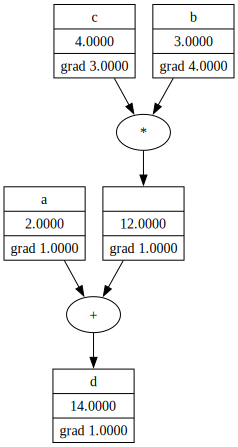

In [51]:
a = Var(2.0, label='a')
b = Var(3.0, label='b')
c = Var(4.0, label='c')
d = a + b * c
d.label = 'd'
#draw_computation_graph(d)
d.backward()
draw_computation_graph(d, forward=True)

In [10]:
random.seed(42)

class Module:
    def __init__(self):
        self.sequential = []
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0

class Perceptron(Module):
    def __init__(self, nin):
        self.weight = [Var(random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Var(random.uniform(-1,1))

    def __call__(self, x):
        out = sum((wi*xi for wi, xi in zip(self.weight, x)), self.bias)
        return out

    def parameters(self):
        return self.weight + [self.bias]
    def __repr__(self):
        return f"Neuron({len(self.weight)})"

class Linear(Module):
    def __init__(self, in_features, out_features):
        self.neurons = [Perceptron(in_features) for _ in range(out_features)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"
class ReLu(Module):
    def __call__(self, x):
        return [i.relu() for i in x] if isinstance(x,list) else x.relu()
    def __repr__(self):
        return "ReLu"
    def parameters(self):
        return []
class Tanh(Module):
    def __call__(self, x):
        return [i.tanh() for i in x] if isinstance(x,list) else x.tanh()
    def __repr__(self):
        return "Tanh"
    def parameters(self):
        return []
# class SoftMax(Module):
#     def __call__(self, x):

class MLP(Module):
    def __init__(self):
        self.sequential = [
            Linear(3,4),
            Tanh(),
            Linear(4,4),
            Tanh(),
            Linear(4,1),
            Tanh()
        ]

    def __call__(self, x):
        x = [list(map(Var, r)) for r in x] if isinstance(x,list) else Var(x)
        preds = []
        for i in x:
            for layer in self.sequential:
               i = layer(i)
            preds.append(i)
        return preds
    def parameters(self):
        return [p for layer in self.sequential for p in layer.parameters()]

In [11]:
def MSELoss(ypred, ytrue):
    return sum((yp - yt)**2 for yp, yt in zip(ypred, ytrue)) / len(ypred)
def BCELoss(ypred, ytrue):
    total_loss = 0
    n = len(ypred)

    for yp, yt in zip(ypred, ytrue):
        yp = Var(min(max(yp.x, 1e-7), 1 - 1e-7))
        total_loss += yt * yp.log() - (Var(1) - yt) * (Var(1) - yp).log()
    return -total_loss / n
def MaxMarginLoss(ypred, ytrue):
    return sum([(1 + -yt*yp).relu() for yt, yp in zip(ytrue, ypred)]) / len(ypred)
def L2Regularization(params, alpha = 1e-4):
    return alpha * sum((p*p for p in params))
class SGD:
    def __init__(self,params, lr):
        self.learning_rate = lr
        self.params = params
    def step(self, schedule=None):
        if schedule:
            self.learning_rate *= schedule
        for p in self.params:
            p.x += -self.learning_rate * p.grad



In [7]:
X = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
y = [1.0, -1.0, -1.0, 1.0]

In [8]:

model = MLP()
criterion = SGD(model.parameters(), 0.1)
for k in range(20):

    ypred = model(X)
    loss = MSELoss(ypred, y)
    model.zero_grad()
    loss.backward()
    criterion.step()

    print(k, loss.x)

0 1.3076293780105586
1 0.9127684663365899
2 0.6675844639305581
3 0.5348072748730223
4 0.41336381427814683
5 0.31994709904392754
6 0.25599062807397027
7 0.21154326506960122
8 0.17903880964833535
9 0.15421985434108063
10 0.1346799850455296
11 0.11895164826235831
12 0.10607248913570719
13 0.0953769014217071
14 0.08638706656376907
15 0.0787506608516838
16 0.07220252603078942
17 0.06653976684242731
18 0.061604925700713103
19 0.057274282747253526


In [ ]:
np.random.seed(1337)
random.seed(1337)
from sklearn.datasets import make_circles
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1

class Moon_MLP(Module):
    def __init__(self):
        self.sequential = [
            Linear(2,16),
            ReLu(),
            Linear(16,16),
            ReLu(),
            Linear(16,1)
        ]
    def __call__(self, x):
        x = [list(map(Var, r)) for r in x] if isinstance(x,list) else Var(x)
        preds = []
        for i in x:
            for layer in self.sequential:
               i = layer(i)
            preds.append(i)
        return preds
    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.sequential)}]"
    def parameters(self):
        return [p for layer in self.sequential for p in layer.parameters()]

model = Moon_MLP()
criterion = SGD(model.parameters(), 1)

for epoch in range(100):


    preds = model(X.tolist())
    loss = MaxMarginLoss(preds, y) + L2Regularization(model.parameters())
    model.zero_grad()
    loss.backward()
    criterion.step(math.exp(-0.001*epoch))

    accuracy = [(yi > 0) == (scorei.x > 0) for yi, scorei in zip(y, preds)]
    acc = sum(accuracy) / len(accuracy)
    print(epoch, loss, f'{acc*100}%')


In [ ]:
np.random.seed(1337)
random.seed(1337)
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    #else:
     #   ri = np.random.permutation(X.shape[0])[:batch_size]
     #   Xb, yb = X[ri], y[ri]

    # forward the model to get scores
    scores = model(Xb.tolist())

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.x > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)
model = Moon_MLP()
criterion = SGD(model.parameters(), 1)
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    criterion.step(math.exp(-0.001*k))

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.x}, accuracy {acc*100}%")

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
scores = model(Xmesh.tolist())
Z = np.array([s.x > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


california = fetch_california_housing(download_if_missing=True)
X = california.data
y = california.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class CH_MLP(Module):
    def __init__(self):
        self.sequential = [
            Linear(13,64),
            ReLu(),
            Linear(64,64),
            ReLu(),
            Linear(64,1)
        ]
    def __call__(self, x):
        x = [list(map(Var, r)) for r in x] if isinstance(x,list) else Var(x)
        preds = []
        for i in x:
            for layer in self.sequential:
               i = layer(i)
            preds.append(i)
        return preds
    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.sequential)}]"
    def parameters(self):
        return [p for layer in self.sequential for p in layer.parameters()]

model = CH_MLP()
criterion = SGD(model.parameters(), 1)

for epoch in range(100):
    preds = model(X_train.tolist())
    loss = MSELoss(preds, y_train) + L2Regularization(model.parameters())
    model.zero_grad()
    loss.backward()
    criterion.step(math.exp(-0.001*epoch))
    print(epoch, loss)

In [ ]:
# test the model
preds = model(X_test.tolist())
test_loss = MSELoss(preds, y_test)
print(f"Test loss: {test_loss.x}")